## Covid19 Prediction Project

#### Data Files:
    • Daily US Report - From 04/12/2020 to 08/31/2020
    • Time Series US
    

In [10]:
#importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

### Load Data


In [11]:
deaths_US_df = pd.read_csv("data/time_series/time_series_covid19_deaths_US.csv", engine="python")
confirmed_US_df = pd.read_csv("data/time_series/time_series_covid19_confirmed_US.csv", engine="python")
confirmed_US_df_copy = confirmed_US_df.copy() 
deaths_US_df_copy = deaths_US_df.copy()
deaths_US_df_copy.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,28,28,28,28,28,28,28,28,28,28
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,65,65,65,65,66,66,67,67,67,67
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,9,9,9,9,9,9,9,9,9,9
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,12,12,12,12,13,13,13,13,13,13
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,16,16,16,16,23,23,23,23,23,23
5,84001011,US,USA,840,1011.0,Bullock,Alabama,US,32.100305,-85.712655,...,16,16,16,16,16,17,17,17,17,17
6,84001013,US,USA,840,1013.0,Butler,Alabama,US,31.753001,-86.680575,...,40,40,40,40,40,40,40,40,40,40
7,84001015,US,USA,840,1015.0,Calhoun,Alabama,US,33.774837,-85.826304,...,49,49,49,49,57,59,59,59,59,59
8,84001017,US,USA,840,1017.0,Chambers,Alabama,US,32.913601,-85.390727,...,43,43,43,43,43,43,43,43,43,43
9,84001019,US,USA,840,1019.0,Cherokee,Alabama,US,34.178060,-85.606390,...,13,13,13,13,14,14,14,14,14,14


#### Dropping undesired dates
We only care from 04/12/2020 to 08/31/2020

In [12]:
def group_states(df, state):
    
    # query all sub-records of the selected state
    tmp_df = df[df["Province_State"]==state]
    
    # create a new row which is to sum all statistics of this state, and 
    # assign the summed value of all sub-records to the date_time column of the new row
    sum_row = tmp_df.sum(axis=0)
    
    # assign the constants to the ['Province/State', 'Country/Region', 'Lat', 'Long'] columns; 
    # note that the Province/State column will be renamed from solely the country name to country name + ", Sum".
    sum_row.loc['UID'] = "NaN"
    sum_row.loc['Admin2'] = "NaN"
    sum_row.loc['FIPS'] = "NaN"
    sum_row.loc['iso2'] = "US"
    sum_row.loc['iso3'] = "USA"
    sum_row.loc['code3'] = 840
    sum_row.loc['Country_Region'] = "US"
    sum_row.loc['Province_State'] = state + ", Sum"
    sum_row.loc['Lat'] = tmp_df['Lat'].values[0]
    sum_row.loc['Long_'] = tmp_df['Long_'].values[0]
    
    # append the new row to the original DataFrame, and 
    # remove the sub-records of the selected country.
    df = pd.concat([df, sum_row.to_frame().T], ignore_index=True)
    #display(df[df["Province_State"].str.contains(state + ", Sum")])
    df=df[df['Province_State'] != state]
    df.loc[df.Province_State == state+", Sum", 'Province_State'] = state
    
    return df

In [13]:
# dropping undesired dates after 8/31/2020 and columns for confirmed_time_series
confirmed_US_df_copy = confirmed_US_df_copy[confirmed_US_df_copy.columns.drop(list(confirmed_US_df_copy.filter(regex= '([1-3]|[9]|1[012])[/]([1-9]|[12][0-9]|3[01])[/](20)')))]
# loop thru all states in the 
for state in confirmed_US_df_copy.Province_State.unique():
    confirmed_US_df_copy = group_states(confirmed_US_df_copy, state)
#after grouping states    
confirmed_US_df_copy.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20
25,NaN,US,USA,840,NaN,NaN,Alabama,US,32.5395,-86.6441,...,114532,115060,116710,117242,119254,121023,122185,123889,125235,126058
26,NaN,US,USA,840,NaN,NaN,Alaska,US,55.3222,-161.972,...,4677,4741,4810,4843,4895,4974,5092,5182,5226,5263
27,NaN,US,USA,840,NaN,NaN,American Samoa,US,-14.271,-170.132,...,0,0,0,0,0,0,0,0,0,0
28,NaN,US,USA,840,NaN,NaN,Arizona,US,35.3947,-109.489,...,197895,198103,198414,199273,199459,200139,200658,201287,201661,201835
29,NaN,US,USA,840,NaN,NaN,Arkansas,US,34.2915,-91.3728,...,56199,56574,56894,57374,58023,58745,59583,60378,60856,61224


In [14]:
# dropping undesired dates after 8/31/2020 and columns for deaths_time_series
deaths_US_df_copy = deaths_US_df_copy[deaths_US_df_copy.columns.drop(list(deaths_US_df_copy.filter(regex= '([1-3]|[9]|1[012])[/]([1-9]|[12][0-9]|3[01])[/](20)')))]
deaths_dates_list = deaths_US_df_copy.columns.tolist()[16:]
# loop thru all states in the 
for state in deaths_US_df_copy.Province_State.unique():
    deaths_US_df_copy = group_states(deaths_US_df_copy, state)
#after grouping states    
deaths_US_df_copy.head(58)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20
25,NaN,US,USA,840,NaN,NaN,Alabama,US,32.5395,-86.6441,...,2011,2013,2024,2037,2045,2076,2107,2152,2162,2182
26,NaN,US,USA,840,NaN,NaN,Alaska,US,55.3222,-161.972,...,31,32,32,36,37,37,37,37,37,37
27,NaN,US,USA,840,NaN,NaN,American Samoa,US,-14.271,-170.132,...,0,0,0,0,0,0,0,0,0,0
28,NaN,US,USA,840,NaN,NaN,Arizona,US,35.3947,-109.489,...,4756,4771,4771,4792,4896,4929,4978,5007,5030,5029
29,NaN,US,USA,840,NaN,NaN,Arkansas,US,34.2915,-91.3728,...,674,687,696,711,732,739,756,772,784,797
30,NaN,US,USA,840,NaN,NaN,California,US,37.6463,-121.893,...,12131,12153,12235,12382,12532,12677,12805,12894,12937,13022
31,NaN,US,USA,840,NaN,NaN,Colorado,US,39.8743,-104.336,...,1918,1918,1919,1926,1927,1931,1937,1942,1942,1945
32,NaN,US,USA,840,NaN,NaN,Connecticut,US,41.2681,-73.3881,...,4460,4460,4460,4463,4463,4465,4465,4465,4465,4465
33,NaN,US,USA,840,NaN,NaN,Delaware,US,39.0865,-75.5688,...,600,600,604,603,604,604,604,604,604,605
34,NaN,US,USA,840,NaN,NaN,Diamond Princess,US,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
states_list = ["Alabama","Alaska","American Samoa","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Diamond Princess","District of Columbia","Florida","Georgia","Grand Princess","Guam","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine", "Maryland", "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey",
"New Mexico", "New York","North Carolina","North Dakota", "Northern Mariana Islands","Ohio","Oklahoma","Oregon","Pennsylvania","Puerto Rico","Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont", "Virgin Islands","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]
dates_list = confirmed_US_df_copy.columns.tolist()[16:]
new_confirmed_df = confirmed_US_df_copy[dates_list].transpose()
new_confirmed_df.columns = states_list 
new_confirmed_df = new_confirmed_df.assign(days=[1 + i for i in range(len(new_confirmed_df))])[['days'] + new_confirmed_df.columns.tolist()]
new_confirmed_df


,days,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
4/6/20,1,1952,190,0,2460,875,16024,5183,6906,783,...,3802,8043,1678,543,43,2878,8311,345,2449,210
4/7/20,2,2169,213,0,2575,946,17351,5429,7781,928,...,4139,8925,1739,575,43,3335,8692,412,2578,216
4/8/20,3,2328,226,0,2726,1000,18897,5655,7781,1116,...,4363,9777,1848,605,45,3645,9276,483,2710,221
4/9/20,4,2703,235,0,3018,1119,19710,6202,9784,1209,...,4634,11208,1856,628,45,4042,9639,514,2886,230
4/10/20,5,2947,246,0,3112,1171,21081,6513,10538,1326,...,4891,12105,2103,679,50,4509,10119,574,3068,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/27/20,144,121023,4974,0,200139,58745,691821,56323,52350,16976,...,149179,614549,50557,1586,1052,116569,72703,9633,73138,3733
8/28/20,145,122185,5092,0,200658,59583,697385,56753,52495,17083,...,150815,619354,50948,1589,1075,117578,73301,9826,73981,3803
8/29/20,146,123889,5182,0,201287,60378,702038,57020,52495,17349,...,152280,626751,51406,1605,1118,118794,73879,9970,74800,3795
8/30/20,147,125235,5226,0,201661,60856,705951,57203,52495,17343,...,153115,629570,51854,1616,1129,119729,74320,10109,75337,3829


In [16]:
new_deaths_df = deaths_US_df_copy[dates_list].T
new_deaths_df.columns = states_list 
new_deaths_df = new_deaths_df.assign(days=[1 + i for i in range(len(new_deaths_df))])[['days'] + new_deaths_df.columns.tolist()]
new_deaths_df

,days,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
4/6/20,1,49,6,0,65,16,380,150,206,15,...,65,182,13,23,1,66,381,4,78,0
4/7/20,2,64,6,0,73,18,432,179,277,16,...,72,195,13,23,1,66,400,4,92,0
4/8/20,3,66,7,0,89,18,495,193,326,19,...,80,221,13,23,1,66,426,4,100,0
4/9/20,4,70,7,0,98,21,544,226,380,23,...,94,247,13,23,1,109,456,5,111,0
4/10/20,5,80,7,0,106,21,583,250,448,32,...,98,272,17,24,1,121,483,5,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/27/20,144,2076,37,0,4929,739,12677,1931,4465,604,...,1673,12365,403,58,14,2527,1890,198,1111,37
8/28/20,145,2107,37,0,4978,756,12805,1937,4465,604,...,1701,12537,407,58,14,2550,1905,201,1113,37
8/29/20,146,2152,37,0,5007,772,12894,1942,4465,604,...,1725,12607,407,58,14,2568,1905,215,1119,37
8/30/20,147,2162,37,0,5030,784,12937,1942,4465,604,...,1747,12683,407,58,14,2569,1905,214,1122,37


In [17]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionModel:

    def __init__(self, model_name, polynomial_degree):
        self.__model_name = model_name
        self.__polynomial_degree = polynomial_degree
        self.__model = None

    def train(self, x, y):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        self.__model = LinearRegression()
        self.__model.fit(x_poly, y)

    def get_predictions(self, x):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        return np.round(self.__model.predict(x_poly), 0).astype(np.int32)

    def get_model_polynomial_str(self):
        coef = self.__model.coef_
        intercept = self.__model.intercept_
        poly = "{0:.3f}".format(intercept)

        for i in range(1, len(coef)):
            if coef[i] >= 0:
                poly += " + "
            else:
                poly += " - "
            poly += "{0:.3f}".format(coef[i]).replace("-", "") + "X^" + str(i)

        return poly

In [18]:
x_confirm = np.array(new_confirmed_df["days"]).reshape(-1, 1)
y_confirm = new_confirmed_df["California"]

In [19]:
regression_model = PolynomialRegressionModel("PR", 2)
regression_model.train(x_confirm, y_confirm)

In [20]:
y_pred = regression_model.get_predictions(x_confirm)
y_pred

array([ 33601,  32960,  32395,  31907,  31496,  31161,  30903,  30722,
        30617,  30589,  30637,  30762,  30964,  31242,  31597,  32029,
        32537,  33122,  33783,  34521,  35336,  36227,  37195,  38239,
        39361,  40558,  41833,  43184,  44611,  46116,  47696,  49354,
        51088,  52899,  54786,  56750,  58790,  60908,  63101,  65372,
        67719,  70143,  72643,  75220,  77873,  80604,  83410,  86294,
        89254,  92290,  95404,  98594, 101860, 105203, 108623, 112119,
       115692, 119342, 123068, 126871, 130750, 134706, 138739, 142849,
       147034, 151297, 155636, 160052, 164545, 169114, 173759, 178482,
       183280, 188156, 193108, 198137, 203242, 208424, 213683, 219018,
       224430, 229919, 235484, 241125, 246844, 252639, 258510, 264459,
       270484, 276585, 282763, 289018, 295349, 301757, 308242, 314803,
       321441, 328155, 334946, 341814, 348758, 355779, 362877, 370051,
       377301, 384629, 392033, 399514, 407071, 414705, 422415, 430202,
      

In [23]:
def print_forecast(model_name, model, beginning_day=0, limit=10):

    next_days_x = np.array(range(beginning_day, beginning_day + limit)).reshape(-1, 1)
    next_days_pred = model.get_predictions(next_days_x)

    print("The forecast for " + model_name + " in the following " + str(limit) + " days is:")
    for i in range(0, limit):
        print("09/" + str(i + 1) + "/2020: " + str(next_days_pred[i]))

In [27]:
print_forecast("Cases using Polynomial Regression", regression_model, 
               beginning_day=len(x_confirm), 
               limit=26)

The forecast for Cases using Polynomial Regression in the following 26 days is:
09/1/2020: 761568
09/2/2020: 772190
09/3/2020: 782889
09/4/2020: 793664
09/5/2020: 804516
09/6/2020: 815445
09/7/2020: 826450
09/8/2020: 837532
09/9/2020: 848690
09/10/2020: 859925
09/11/2020: 871237
09/12/2020: 882625
09/13/2020: 894090
09/14/2020: 905632
09/15/2020: 917250
09/16/2020: 928945
09/17/2020: 940716
09/18/2020: 952564
09/19/2020: 964489
09/20/2020: 976490
09/21/2020: 988568
09/22/2020: 1000722
09/23/2020: 1012953
09/24/2020: 1025261
09/25/2020: 1037646
09/26/2020: 1050107


In [28]:
import operator

def plot_graph(model_name, x, y, y_pred):

    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)

    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

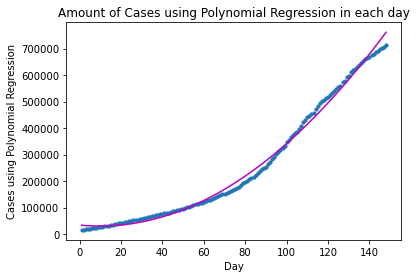

In [29]:
plot_graph("Cases using Polynomial Regression", x_confirm, y_confirm, y_pred)